## Explaining CNN's

## Objective: Explain some basic concepts about CNNs.


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch

# Convolution

In [2]:
def show_img(img):
    fig, ax = plt.subplots()
    plt.imshow(img, cmap='gray')
    for (i, j), z in np.ndenumerate(img):
        ax.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=6)
    plt.show()

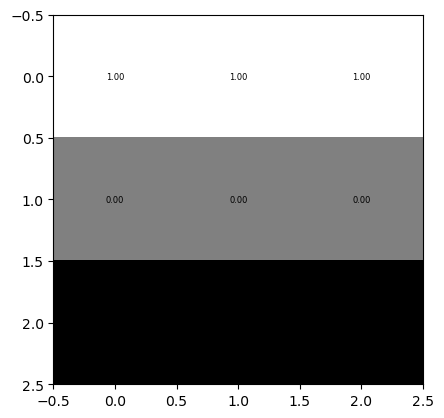

In [3]:
# This kernel detect horizontal edge
kernel = torch.tensor([[1,1,1],
                       [0,0,0],
                       [-1,-1,-1]])
show_img(kernel)

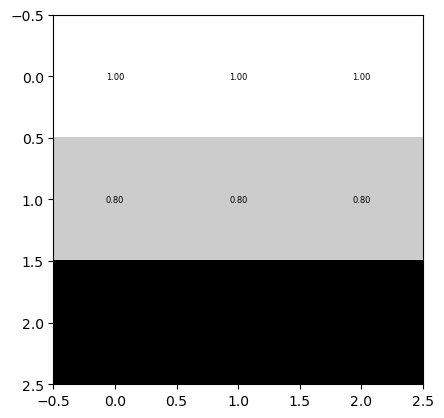

In [56]:
piece_of_image = torch.tensor([[1,1,1],
                       [0.8,0.8,0.8],
                       [0,0,0]])
show_img(piece_of_image)

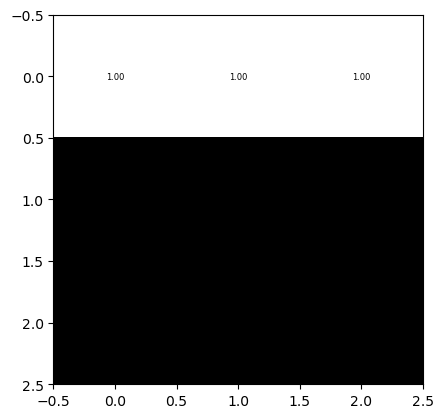

In [28]:
result = (piece_of_image * kernel)
show_img(result)

In [6]:
result.sum() # Result of the convolution

tensor(3.)

# Pooling

In [7]:
def max_polling(img):
    print(torch.max(img))

### Max Pooling

Just pick up the max value inside the matrix you have, not very used in real world problems, as we have another method called Average pooling which have better results in complex data. But still you can use these two together, like an ensembling.

In [8]:
max_polling(piece_of_image)

tensor(1.)


# Dropout

A good way to deal with overfitting, basically delete random bits based on a dropout factor.

In [51]:
def dropout(img, factor = 0.5):
    random_tensor = torch.rand((3,3))
    dropout_filter = torch.zeros((3,3))
    
    for i in range(dropout_filter.shape[0]):
        for j in range(dropout_filter.shape[1]): 
            dropout_filter[i][j] = 1 if random_tensor[i][j] > factor else 0
    return img * dropout_filter

### Original image

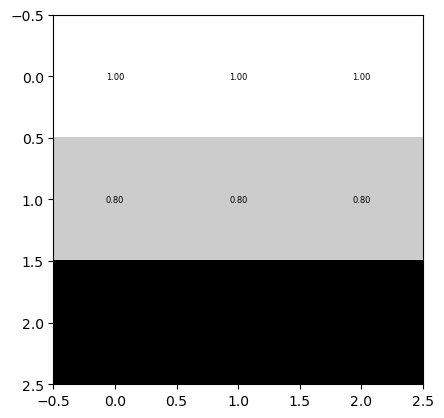

In [52]:
show_img(piece_of_image)

### Original image but dropped

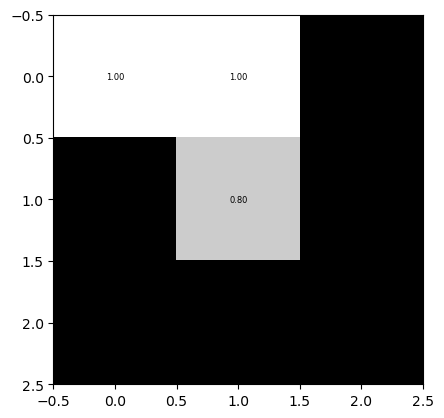

In [57]:
piece_of_image_dropped = dropout(piece_of_image)
show_img(piece_of_image_dropped)

### Testing dropout factor

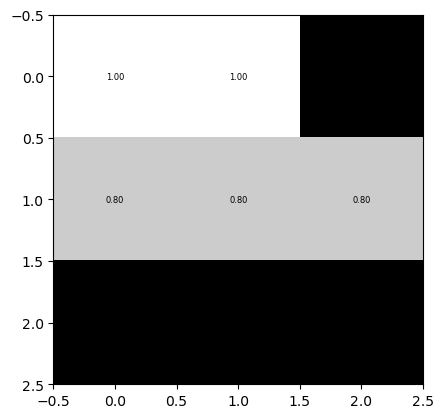

In [58]:
piece_of_image_dropped = dropout(piece_of_image, 0.2)
show_img(piece_of_image_dropped)

## Building the model

In [9]:
!pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


## Step 1: Download images of drunk person and non-drunk person

In [10]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [11]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('iphone', max_images=1)
urls[0]

Searching for 'iphone'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://static6.businessinsider.com/image/55a02036eab8ea815ff7425b/apples-new-iphone-update-is-making-the-home-screen-obsolete-for-me.jpg'

...and then download a URL and take a look at it:

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


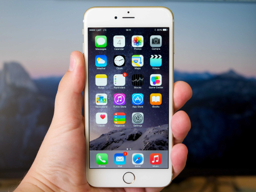

In [12]:
from fastdownload import download_url
dest = 'iphone.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "normal person photos":

Searching for 'samsung smartphone latest'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


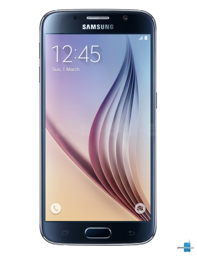

In [13]:
download_url(search_images('samsung smartphone latest', max_images=1)[0], 'samsung.jpg', show_progress=False)
Image.open('samsung.jpg').to_thumb(256,256)

In [14]:
searches = 'samsung smartphone','iphone'
path = Path('iphone_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} latest'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'samsung smartphone'
Searching for 'samsung smartphone latest'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'iphone'
Searching for 'iphone latest'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

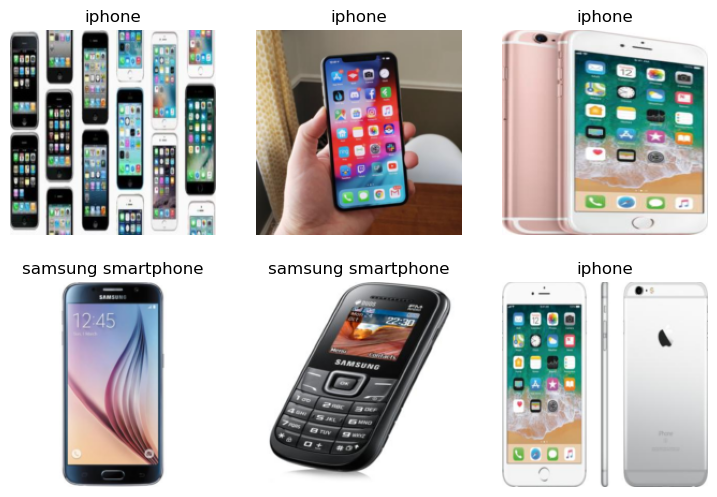

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.353084,0.959248,0.409091,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.929367,0.723668,0.363636,00:12
1,0.761443,0.422486,0.136364,00:12
2,0.570605,0.374892,0.090909,00:12
3,0.442819,0.357093,0.136364,00:12
4,0.369751,0.317933,0.090909,00:12


## Step 3: Use our model

In [21]:
is_iphone,_,probs = learn.predict(PILImage.create('iphone.jpg'))
print(f"This is a: {is_iphone}.")
print(f"Probability it's a Iphone: {probs[0]:.4f}")

This is a: iphone.
Probability it's a Iphone: 0.9994


# Step 4: Export our model

In [24]:
learn.export('model.pkl')

# Deploy
Link: https://huggingface.co/spaces/BrunoHenrique00/lesson8